<a href="https://jupyterhub.user.eopf.eodc.eu/hub/user-redirect/git-pull?repo=https://github.com/eopf-toolkit/eopf-101&branch=main&urlpath=lab/tree/eopf-101/34_eopf_stac_xarray_tutorial.ipynb" target="_blank">
  <button style="background-color:#0072ce; color:white; padding:0.6em 1.2em; font-size:1rem; border:none; border-radius:6px; margin-top:1em;">
    🚀 Launch this notebook in JupyterLab
  </button>
</a>

### Introduction

In this tutorial we will demonstrate how to access `EOPF Zarr` products directly from the [EOPF Sentinel Zarr Sample Service STAC Catalog](https://stac.browser.user.eopf.eodc.eu/?.language=en).

### What we will learn

- ☁️ How to open cloud-optimised datasets from the EOPF Zarr STAC Catalog with `xarray`
- 🔎 Examine loaded datasets
- 📊 Perform simple data analyses with the loaded data

### Prerequisites

This tutorial requires the `xarray-eopf` extension for data manipulation. To find out more about the library, access the [documentation](https://eopf-sample-service.github.io/xarray-eopf/).

It is advised that you go through the previous [section](33_eopf_stac_connection.ipynb), as it gives you an introduction on how to programmatically access a STAC catalog.

<hr>

#### Import libraries

In [8]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional, cast
from pystac import Collection, MediaType
from pystac_client import Client, CollectionClient
from datetime import datetime
import xarray as xr

#### Helper functions

##### `list_found_elements`
As we are expecting to visualise several elements that will be stored in lists, we define a function that will allow us retrieve item `id`'s and collections `id`'s for further retrieval.

In [9]:
def list_found_elements(search_result):
    id = []
    coll = []
    for item in search_result.items(): #retrieves the result inside the catalogue.
        id.append(item.id)
        coll.append(item.collection_id)
    return id , coll

<hr>

## Establish a connection to the EOPF Zarr STAC Catalog

Our first step is to a connection to the EOPF Zarr STAC Catalog. This involves defining the `url` of the STAC endpoint. See the previous [section](./33_eopf_stac_connection.ipynb) for a more detailed explanation how to retrieve the end point `url`.

Through the `Client.open()` function, we can establish the connection to the EOPF Zarr STAC catalog by providing the specific `url`.

In [10]:
max_description_length = 100

eopf_stac_api_root_endpoint = "https://stac.core.eopf.eodc.eu/" #root starting point
eopf_catalog = Client.open(url=eopf_stac_api_root_endpoint)

# eopf_catalog  #print to have an interative visualisation

## Filtering for items of interest

For this tutorial, we will focus on the Sentinel-2 L2A Collection. The EOPF STAC Catalog corresponding `id` is: `sentinel-2-l2a`.

As we are interested in retrieving and exploring an Item from the collection, we will focus again over the Innsbruck area we have defined in the [previous tutorial](./33_eopf_stac_connection.ipynb).

In [11]:
innsbruck_s2 = eopf_catalog.search( # searching in the Catalog
    collections= 'sentinel-2-l2a', # interest Collection,
    bbox=(11.124756, 47.311058, # AOI extent
          11.459839,47.463624),
    datetime='2020-05-01T00:00:00Z/2025-05-31T23:59:59.999999Z' # interest period
)

combined_ins =list_found_elements(innsbruck_s2)

print("Search Results:")
print('Total Items Found for Sentinel-2 L-2A over Innsbruck:  ',len(combined_ins[0]))

Search Results:
Total Items Found for Sentinel-2 L-2A over Innsbruck:   27


Let us now select the first Item in the list of 27 Items.

In [12]:
first_item_id=combined_ins[0][0]
print(first_item_id)

S2B_MSIL2A_20250530T101559_N0511_R065_T32TPT_20250530T130924


In a next step, we retrieve the `url` of the cloud location for the specific item and  load the selected Item with the help of `xarray`.

In [13]:
c_sentinel2 = eopf_catalog.get_collection('sentinel-2-l2a')
#Choosing the first item available to be opened:
item= c_sentinel2.get_item(id=first_item_id)
item_assets = item.get_assets(media_type=MediaType.ZARR)

cloud_storage = item_assets['product'].href

print('Item cloud storage URL for retrieval:',cloud_storage)

Item cloud storage URL for retrieval: https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202505-s02msil2a/30/products/cpm_v256/S2B_MSIL2A_20250530T101559_N0511_R065_T32TPT_20250530T130924.zarr


## Examining Dataset Structure

In the following step, we open the cloud-optimised Zarr dataset using `xarray.open_datatree` supported by the `zarr` engine.

The subsequent loop then prints out all the available groups within the opened `DataTree`, providing a comprehensive overview of the hierarchical structure of the EOPF Zarr products.

In [14]:
import dask                             # these last two libraries are imported to open the datasets faster
from dask.distributed import Client     # and in the end take advantage of the optimized .zarr format
client = Client()  # Set up local dask cluster
client

dt = xr.open_datatree(
    cloud_storage,     # the cloud storage url from the Item we are interested in
    engine="zarr",
    chunks="auto"      # automatically determine chunk sizes using dask
)

for dt_group in sorted(dt.groups):
    print("DataTree group {group_name}".format(group_name=dt_group)) # getting the available groups

/home/emathot/Workspace/eopf-toolkit/eopf-101/.venv/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46305 instead
  warnings.warn(
/tmp/ipykernel_1402310/1911136241.py:6: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dt = xr.open_datatree(
/tmp/ipykernel_1402310/1911136241.py:6: FutureWarning: In a future version, xarray will not d

DataTree group /
DataTree group /conditions
DataTree group /conditions/geometry
DataTree group /conditions/mask
DataTree group /conditions/mask/detector_footprint
DataTree group /conditions/mask/detector_footprint/r10m
DataTree group /conditions/mask/detector_footprint/r20m
DataTree group /conditions/mask/detector_footprint/r60m
DataTree group /conditions/mask/l1c_classification
DataTree group /conditions/mask/l1c_classification/r60m
DataTree group /conditions/mask/l2a_classification
DataTree group /conditions/mask/l2a_classification/r20m
DataTree group /conditions/mask/l2a_classification/r60m
DataTree group /conditions/meteorology
DataTree group /conditions/meteorology/cams
DataTree group /conditions/meteorology/ecmwf
DataTree group /measurements
DataTree group /measurements/reflectance
DataTree group /measurements/reflectance/r10m
DataTree group /measurements/reflectance/r20m
DataTree group /measurements/reflectance/r60m
DataTree group /quality
DataTree group /quality/atmosphere
Data

## Root Dataset Metadata


We specifically look for groups containing data variables under `/measurements/reflectance/r20m` (which corresponds to Sentinel-2 bands at 20m resolution). The output provides key information about the selected group, including its dimensions, available data variables (the different spectral bands), and coordinates.

In [15]:
# Get /measurements/reflectance/r20m group
groups = list(dt.groups)
interesting_groups = [
    group for group in groups if group.startswith('/measurements/reflectance/r20m')
    and dt[group].ds.data_vars
]
print(f"\n🔍 Searching for groups with data variables in '/measurements/reflectance/r20m'...")



🔍 Searching for groups with data variables in '/measurements/reflectance/r20m'...


In [16]:
if interesting_groups:
    sample_group = interesting_groups[0]
    group_ds = dt[sample_group].ds
    
    print(f"Group '{sample_group}' Information")
    print("=" * 50)
    print(f"Dimensions: {dict(group_ds.dims)}")
    print(f"Data Variables: {list(group_ds.data_vars.keys())}")
    print(f"Coordinates: {list(group_ds.coords.keys())}")

else:
    print("No groups with data variables found in the first 5 groups.")

Group '/measurements/reflectance/r20m' Information
Dimensions: {'y': 5490, 'x': 5490}
Data Variables: ['b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b11', 'b12', 'b8a']
Coordinates: ['x', 'y']


/tmp/ipykernel_1402310/1451209294.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Dimensions: {dict(group_ds.dims)}")


In a next step, we inspect the attributes of the root dataset within the `DataTree`. Attributes often contain important high-level metadata about the entire product, such as processing details, STAC discovery information, and more. We print the first few attributes to get an idea of the available metadata.


In [17]:
# Examine the root dataset
root_dataset = dt.ds

print("Root Dataset Metadata")

if root_dataset.attrs:
    print(f"\nAttributes (first 3):")
    for key, value in list(root_dataset.attrs.items())[:3]:
        print(f"   {key}: {str(value)[:80]}{'...' if len(str(value)) > 80 else ''}")

Root Dataset Metadata

Attributes (first 3):
   other_metadata: {'AOT_retrieval_model': 'SEN2COR_DDV', 'L0_ancillary_data_quality': '4', 'L0_eph...
   stac_discovery: {'assets': {'analytic': {'eo:bands': [{'center_wavelength': 0.4423, 'common_name...


## Visualising the RGB quicklook composite

EOPF Zarr Assets include a quick-look RGB composite, which we now want to open and visuliase. We open the Zarr dataset again, but this time, we specifically target the `quality/l2a_quicklook/r20m group` and its variables.

This group typically contains a true colour (RGB) quick-look composite, which is a readily viewable representation of the satellite image. 

We use `xr.open_dataset()` and specify the following set of arguments in order to load the quick-look.

In [18]:
## Visualising the RGB quicklook composite:
ds = dt['quality/l2a_quicklook/r20m'].to_dataset()
ds_20_ql= ds['tci']

As soon as we load the selected group, we can create a simple plot with `imshow()` to see the quick-look.

(np.float64(600000.0),
 np.float64(709800.0),
 np.float64(5190240.0),
 np.float64(5300040.0))

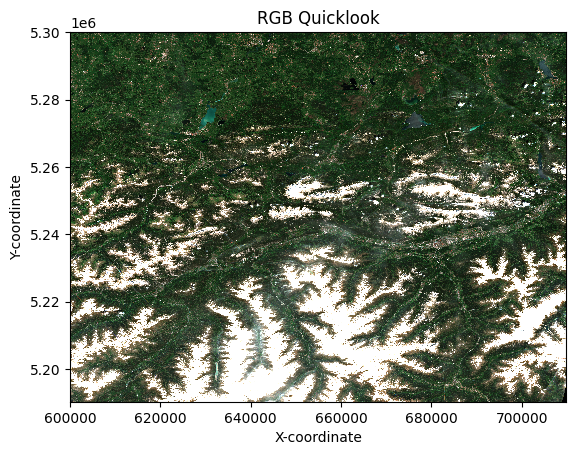

In [19]:
ds_20_ql.plot.imshow(rgb="band")
plt.title('RGB Quicklook')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(False) # Turn off grid for image plots
plt.axis('tight') # Ensure axes fit the data tightly

## Simple Data Analysis: Calculating NDVI

Let us now do a simple analysis with the data from the EOPF Zarr STAC Catalog. Let us calculate the Normalized Difference Vegetation Index (NDVI).

First, we access the `/measurements/reflectance/r20m` group, as the bands we are interested in are at 20m resolution: the **Red** (B04) and **Near-InfraRed** (B08A) bands, which are ones needed for the calculation of the NDVI.

In [20]:
# Visualising the NIR reflectance band and select a subsample region with a specific bounding box and a specific resolution.
resolution = 2000  # in meters
red_nir = dt ['/measurements/reflectance/r20m'].to_dataset()
red_nir.isel(
    x=slice(
        red_nir['x'].min().values.flat[0],
        int(red_nir['x'].min().values.flat[0] + 100000),
        int(resolution/20),
    ),
    y=slice(
        red_nir['y'].min().values.flat[0],
        int(red_nir['y'].min().values.flat[0] + 100000),
        int(resolution/20),
    )
)

<xarray.Dataset> Size: 0B
Dimensions:  (y: 0, x: 0)
Coordinates:
  * x        (x) int64 0B 
  * y        (y) int64 0B 
Data variables:
    b01      (y, x) float64 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
    b02      (y, x) float64 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
    b03      (y, x) float64 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
    b04      (y, x) float64 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
    b05      (y, x) float64 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
    b06      (y, x) float64 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
    b07      (y, x) float64 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
    b11      (y, x) float64 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
    b12      (y, x) float64 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
    b8a      (y, x) float64 0B dask.array<chunksize=(0, 0), meta=np.ndarray>

In a next step, we cast the red (B04) and Near-Infrared (B08a) arrays. This is important for accurate mathematical operations, which we will conduct in the next cell.

In [21]:
red_f = red_nir['b04']
nir_f = red_nir['b8a']

Now, we perform the initial steps for **NDVI** calculation:
- `sum_bands`: Calculates the sum of the Near-Infrared and Red bands.
- `diff_bands`: Calculates the difference between the Near-Infrared and Red bands.

In [22]:
sum_bands = nir_f + red_f
diff_bands = nir_f - red_f
ndvi = diff_bands / sum_bands

To prevent division by zero errors in areas where both red and NIR bands might be zero (e.g., water bodies or clouds), this line replaces any **NaN** values resulting from division by zero with the 0 value. This ensures a clean and robust NDVI product.

In [23]:
ndvi = ndvi.where(sum_bands != 0, 0)

In a final step, we can visualise the calculated NDVI.

/home/emathot/Workspace/eopf-toolkit/eopf-101/.venv/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/home/emathot/Workspace/eopf-toolkit/eopf-101/.venv/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


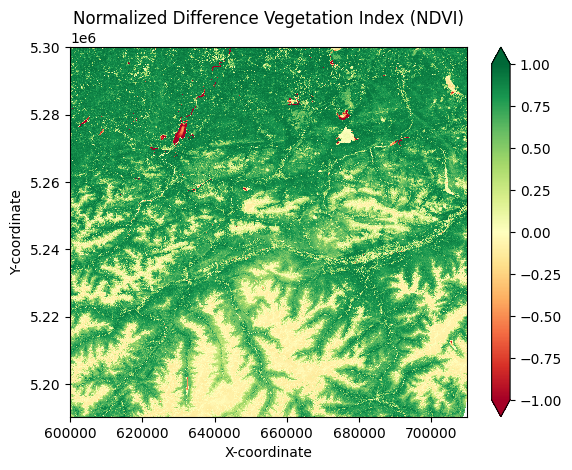

In [24]:
ndvi.plot(cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('Normalized Difference Vegetation Index (NDVI)')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(False) # Turn off grid for image plots
plt.axis('tight') # Ensure axes fit the data tightly

# Display the plot
plt.show()

## 💪 Now it is your turn

With the foundations learned so far, you are now equipped to access products from the EOPF Zarr STAC catalog. These are your tasks:

### Task 1: Explore five additional Sentinel-2 Items for Innsbruck
Replicate the RGB quick-look and have an overview of the spatial changes.

### Task 2: Calculate NDVI
Replicate the NDVI calculation for the additional Innsbruck items.

### Task 3: Applying more advanced analysis techniques
The EOPF STAC Catalog offers a wealth of data beyond Sentinel-2. Replicate the search and data access for data from other collections.

## Conclusion

In this section we established a connection to the [EOPF Sentinel Zarr Sample Service STAC Catalog](https://stac.browser.user.eopf.eodc.eu/?.language=en) and directly accessed an EOPF Zarr item with `xarray`. In the tutorial you are guided through the process of opening hierarchical EOPF Zarr products using `xarray`'s `DataTree`, a library designed for accessing complex hierarchical data structures.


## What's next?

This online resource is under active development. So stay tuned for regular updates.